#**Hierarchical Graph Representation Learning with Differentiable Pooling**

By: Thierno Diallo

Find below the links to the original paper:

*   ArXiv: https://arxiv.org/abs/1806.08804
*   Code Repository: https://github.com/RexYing/diffpool

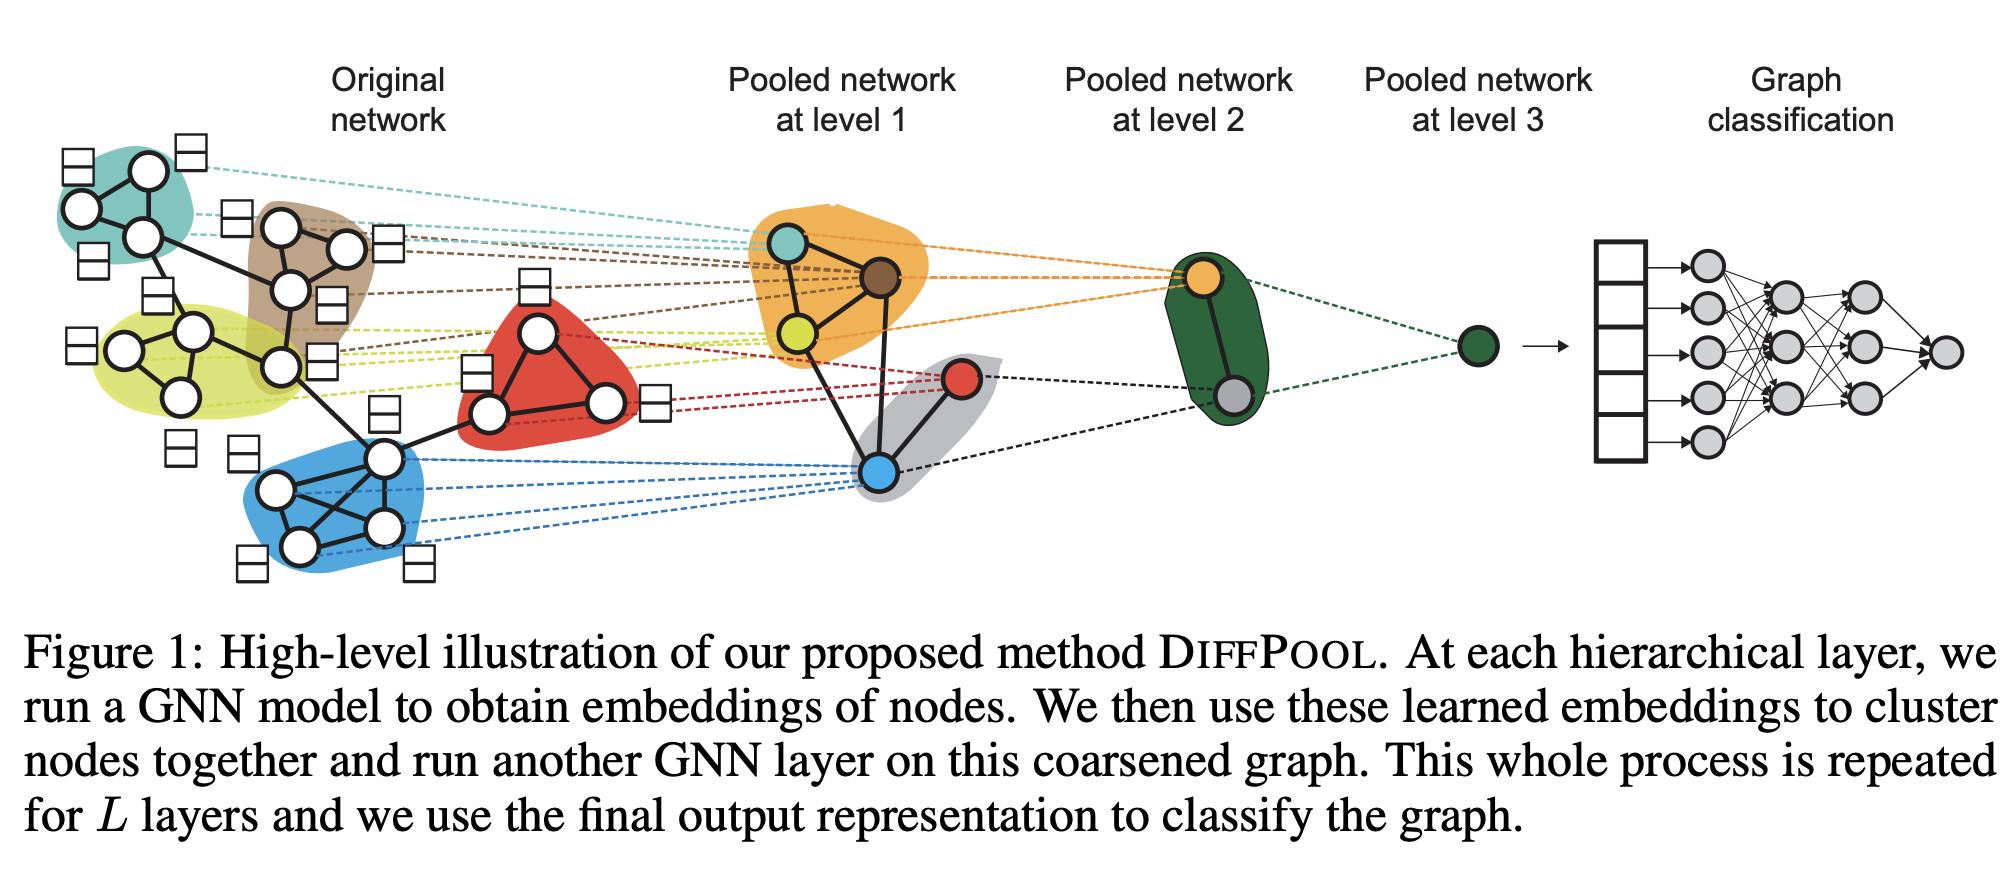

Differentialable Pooling (DiffPooling) is a hierarchical graph pooling method designed for graph-level representation learning in Graph Neural Networks (GNNs). It dynamically learns to group nodes into clusters during training by generating node embeddings and a soft assignment matrix that maps nodes to clusters. This process aggregates node features and adjacency matrices into coarsened representations, enabling the model to capture hierarchical structures often present in real-world graphs like molecules, social networks, and biological systems. By progressively reducing the graph size, DiffPooling focuses on high-level information while retaining key structures and feature making it well-suited for applications like predicting molecules and drugs and hierarchical data modeling. In this notebook we will walk you through a basic DiffPool model using a graph dataset of protein structures.

In [1]:
# Install necessary libraries
!pip install torch torchvision torch-geometric matplotlib networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.3 MB/s eta 0:00:00


## Differentialable Pooling With Small Graph (Indepth Walkthough)

In this section, we will walkthough differential pooling with three pooling layers using a small graph with 20 nodes and 32 features each to understand the implemntation and intuition behind this pooling method.

In [2]:
# imports
import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.colors as mcolors

### Visualization

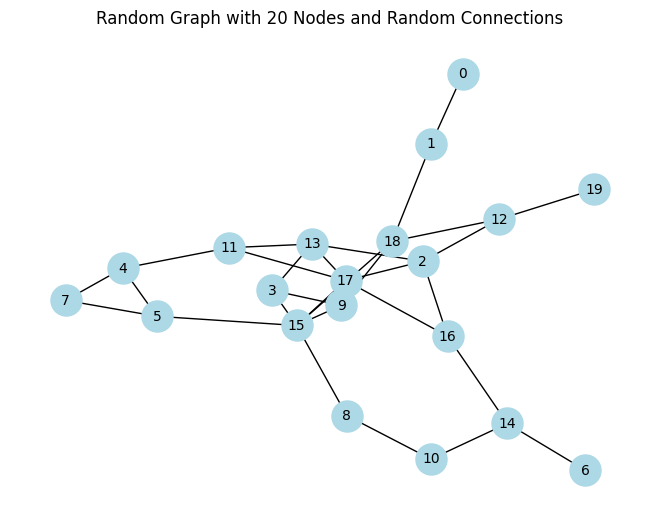

In [3]:
# Create graph
num_nodes = 20
num_features = 32
num_edges = 30

# Create graph with nodes and edges
np.random.seed(2025) # For reproducibility
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
edge_set = set()
while len(edge_set) < num_edges:
    edge = tuple(np.random.choice(num_nodes, 2, replace=False))
    edge_set.add(edge)
G.add_edges_from(edge_set)

# Plot Graph
pos = nx.spring_layout(G, seed=42) # For reproducibility
nx.draw(
    G,
    pos=pos,
    with_labels=True,
    node_color='lightblue',
    node_size=500,
    font_size=10
)
plt.title("Random Graph with 20 Nodes and Random Connections")
plt.show()

With this input graph, now we can proceed to the first step of applying **differentiable pooling** to learn node embeddings and generate the soft cluster assignments.

First, we compute the node embeddings using a graph neural network (GNN) with the adjacency matrix $\mathbf{A}$ and node features $\mathbf{X}$:

$$
\mathbf{Z} = \text{GNN}_{\text{embed}}(\mathbf{A}, \mathbf{X})
$$

Next, we compute the soft cluster assignment matrix, $\mathbf{S}$, using a softmax operation over the output of another GNN applied to the same graph:

$$
\mathbf{S} = \text{softmax}(\text{GNN}_{\text{pool}}(\mathbf{A}, \mathbf{X}))
$$

Here:
- $\mathbf{Z}$ represents the node embeddings learned by the GNN. We can use any GNN for this step.
- $\mathbf{S}$ is the soft cluster assignment matrix, where each row corresponds to a node and the columns represent probabilities of belonging to each cluster. The number of clusters is determined at each step, and applying the softmax gives us the probability that a node belongs to a specific cluster.

---

### Constructing the New Graph

Next step, we construct the new graph by first calculating the **embeddings** $\mathbf{X}'$ for each cluster and then the **new adjacency matrix** $\mathbf{A}'$ that connects the clusters:

$$
\mathbf{X}' = \mathbf{S}^\top \mathbf{Z}
$$

$$
\mathbf{A}' = \mathbf{S}^\top \mathbf{A} \mathbf{S}
$$

Here:
1. $\mathbf{X}'$ is the aggregate node embeddings of $\mathbf{Z}$ into new embeddings for the clusters based on the soft assignments in $\mathbf{S}$.
2. $\mathbf{A}'$ is coarsen adjacency matrix of $\mathbf{A}$ to represent the connectivity between the new clusters.

We repeat this process for each pooling layer to progressively coarsen the graph into fewer clusters while retaining critical structural information.



Node embeddings torch.Size([20, 16]): 
 tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 5.8151e-01, 0.0000e+00],
        [1.8564e-01, 8.8826e+00, 3.2536e+00, 4.4343e+00, 7.2102e+00, 2.7475e+00,
         6.8445e+00, 2.3465e+00, 2.6897e+00, 5.9359e-01, 3.9615e-01, 8.7875e-01,
         3.9184e+00, 4.7716e+00, 6.3631e+00, 3.5966e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [7.9820e-01, 4.2962e+00, 2.9426e+00, 4.8893e+00, 6.3629e+00, 3.1221e+00,
         4.0070e+00, 1.5623e+00, 1.9830e+00, 0.0000e+00, 5.6895e+00, 0.0000e+00,
         5.3246e+00, 3.2482e+00, 1.6253e+00, 7.1876e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

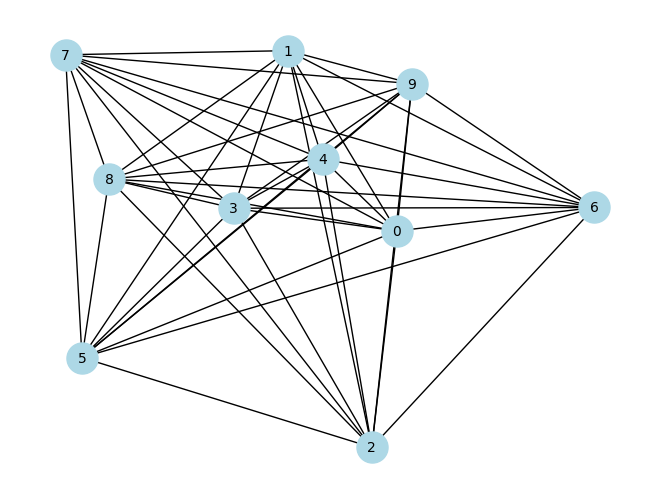

In [7]:
def visualizeGraph(A):
  g_new = nx.from_numpy_array(A.detach().numpy(), create_using=nx.Graph)
  g_new.remove_edges_from(nx.selfloop_edges(g_new))
  nx.draw(g_new,
    with_labels=True,
    node_color='lightblue',
    node_size=500,
    font_size=10)
  return plt.show()
# Compute Adjacency
A = nx.adjacency_matrix(G).todense()
A = torch.tensor(A, dtype=torch.float32)

# Create node features for each node
X = torch.randn(num_nodes, num_features)

# First pooling layer (10 clusters)
n_clusters_1 = 10
w_gnn_emb = torch.rand(32, 16)
w_gnn_pool = torch.rand(32, n_clusters_1)

# Compute node embeddings
Z = torch.relu(A @ X @ w_gnn_emb)

# Print to see hwo dimmesions changed
print(f"Node embeddings {Z.shape}: \n", Z)

# Compute soft cluster assignment matrix
S = torch.softmax(A @ X @ w_gnn_pool, dim=1)

# Print to see hwo dimmesions changed
print(f"Cluster assignment matrix {S.shape}: \n", S)

# Compute new adjaceny and cluster connecttivity
X_1 = S.T @ Z
A_1 = S.T @ A @ S

#Visualize new clusters
visualizeGraph(A_1)

tensor([8, 6, 1, 4, 3, 9, 0, 8, 4, 9, 0, 7, 0, 9, 5, 3, 8, 4, 4, 1])


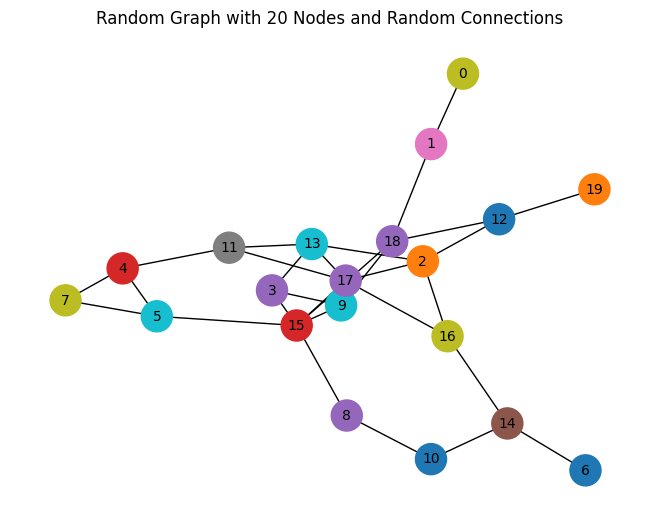

In [13]:
# Here we visualize each node in its most likely cluster. First we
# convert soft assignments to hard assignments
# by computing the most likely cluster (column) for each node (row)
cluster_assignments = torch.argmax(S, dim=1)
print(cluster_assignments)
# Define 10 unique colors for each cluster
unique_colors = list(mcolors.TABLEAU_COLORS.values())[:10]

# Assign each node a color based on its cluster assignment
node_colors = [unique_colors[cluster.item()] for cluster in cluster_assignments]

nx.draw(
    G,
    pos=pos,
    with_labels=True,
    node_color=node_colors,
    node_size=500,
    font_size=10
)
plt.title("Random Graph with 20 Nodes and Random Connections")
plt.show()


Node embeddings torch.Size([10, 8]): 
 tensor([[345.2120, 505.0968, 324.7437, 513.7135, 486.0301, 310.8639, 394.4583,
         482.1168],
        [279.2150, 427.4918, 293.7129, 419.1524, 412.9331, 260.1707, 320.1313,
         403.3400],
        [ 56.3395,  84.8758,  59.0923,  85.0974,  82.8877,  52.7937,  65.0451,
          80.2830],
        [327.2034, 484.8308, 317.3716, 486.7381, 466.7670, 296.1518, 372.0872,
         463.3110],
        [509.9815, 793.0711, 561.2179, 771.8533, 769.9873, 483.2580, 589.6526,
         744.5797],
        [ 76.0676, 115.8927,  77.9409, 114.1149, 111.5690,  70.8667,  87.3698,
         108.4675],
        [148.5592, 224.2485, 152.6420, 222.8879, 217.0655, 137.4745, 170.3773,
         212.6860],
        [150.9611, 229.5550, 163.2841, 229.1168, 224.9556, 141.5407, 175.0552,
         219.2496],
        [224.5374, 335.6154, 227.1872, 336.5012, 325.4756, 206.3980, 257.3098,
         319.6200],
        [272.8911, 409.6504, 275.7969, 411.4539, 396.6937, 251.9781, 3

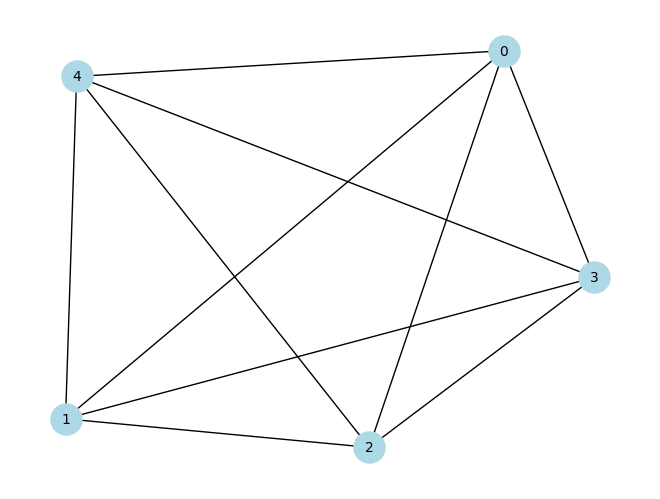

In [14]:
# Second Pooling Layer
n_clusters_2 = 5

# Initialzie weights again because this our first forward pass
w_gnn_emb_2 = torch.rand(16, 8)
w_gnn_pool_2 = torch.rand(16, n_clusters_2)

# Compute node embeddings
Z_2 = torch.relu(A_1 @ X_1 @ w_gnn_emb_2)

# Print to see hwo dimmesions changed
print(f"Node embeddings {Z_2.shape}: \n", Z_2)

# Compute soft cluster assignment matrix
S_2 = torch.softmax(A_1 @ X_1 @ w_gnn_pool_2, dim=1)

# Print to see hwo dimmesions changed
print(f"Cluster assignment matrix {S_2.shape}: \n", S_2)

# Compute new adjaceny and cluster connecttivity
X_2 = S_2.T @ Z_2
A_2 = S_2.T @ A_1 @ S_2

#Visualize new clusters
visualizeGraph(A_2)

Node embeddings torch.Size([5, 4]): 
 tensor([[7.0598e+05, 3.6554e+05, 6.0998e+05, 4.8638e+05],
        [1.3751e-06, 7.1199e-07, 1.1881e-06, 9.4737e-07],
        [3.8242e-02, 1.9801e-02, 3.3042e-02, 2.6347e-02],
        [1.0781e+01, 5.5821e+00, 9.3148e+00, 7.4275e+00],
        [1.5594e-05, 8.0742e-06, 1.3473e-05, 1.0743e-05]])
Cluster assignment matrix torch.Size([5, 2]): 
 tensor([[1.0000, 0.0000],
        [0.5000, 0.5000],
        [0.5012, 0.4988],
        [0.7980, 0.2020],
        [0.5000, 0.5000]])


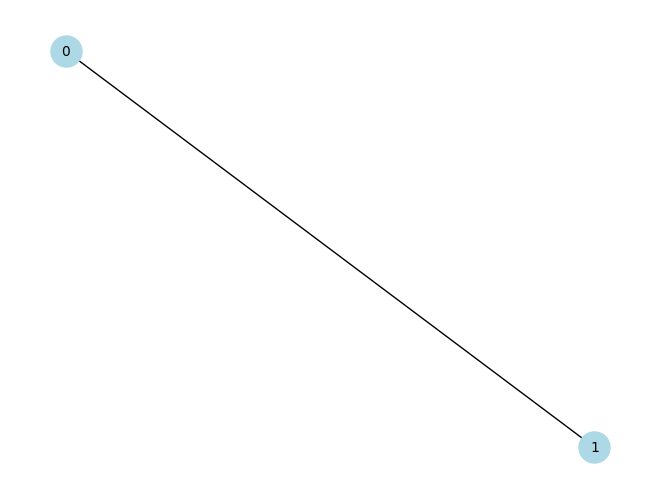

In [15]:
# Third Pooling Layer
n_clusters_3 = 2

# Initialzie weights again because this our first forward pass
w_gnn_emb_3 = torch.rand(8, 4)
w_gnn_pool_3 = torch.rand(8, n_clusters_3)

# Compute node embeddings
Z_3 = torch.relu(A_2 @ X_2 @ w_gnn_emb_3)

# Print to see hwo dimmesions changed
print(f"Node embeddings {Z_3.shape}: \n", Z_3)

# Compute soft cluster assignment matrix
S_3 = torch.softmax(A_2 @ X_2 @ w_gnn_pool_3, dim=1)

# Print to see hwo dimmesions changed
print(f"Cluster assignment matrix {S_3.shape}: \n", S_3)

# Compute new adjaceny and cluster connecttivity
X_3 = S_3.T @ Z_3
A_3 = S_3.T @ A_2 @ S_3

#Visualize new clusters
visualizeGraph(A_3)

## General Differential Pooling For Protein Classification

Now that we have walked through one forward propagation with differntial pooling to gain intuiton on how the each pooling layer works, we will look at a more general and advanced application of differential pooling to extract hierarchical representations of our graph. Here, we will look at a dataset of proteins and apply differential pooling with more sophisticated GNN layers compared to before. Here, we are classifying proteins as enzymes or not.

In [16]:
# Imports
import os.path as osp
from math import ceil

import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader
from torch_geometric.nn import DenseGCNConv as GCNConv, dense_diff_pool

In [17]:
# The biggest graph we want should be 150 nodes. This makes it
# easier to compute, but also to set the clusters per pooling layer.
max_nodes = 150

class FIterData(object):
    def __call__(self, data):
        return data.num_nodes <= max_nodes

# Load dataset
# Here we add zero padding for smaller graphs
dataset = TUDataset('data', name='PROTEINS', transform=T.ToDense(max_nodes),
                    pre_filter=FIterData(), force_reload=True)

# Partion Dataset
train_size = int(0.8 * len(dataset))
test_size = int(0.1 * len(dataset))
val_size = int(len(dataset) - train_size - test_size)
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])
test_loader = DenseDataLoader(test_dataset, batch_size=32)
val_loader = DenseDataLoader(val_dataset, batch_size=32)
train_loader = DenseDataLoader(train_dataset, batch_size=32)

Processing...
Done!


In [26]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 normalize=False):
        super(GNN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        self.convs.append(GCNConv(in_channels, hidden_channels, normalize))
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))

        self.convs.append(GCNConv(hidden_channels, hidden_channels, normalize))
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))

        self.convs.append(GCNConv(hidden_channels, out_channels, normalize))
        self.bns.append(torch.nn.BatchNorm1d(out_channels))


    def forward(self, x, adj, mask=None):
        batch_size, num_nodes, in_channels = x.size()

        for step in range(len(self.convs)):
            x = F.relu(self.convs[step](x, adj, mask))
            # Adjust the number of features for BatchNorm1d
            # The x.size(2) retrieves the current number of features
            # after convolution operation
            x = self.bns[step](x.view(batch_size * num_nodes, -1)).view(batch_size, num_nodes, -1)
        return x


class DiffPool(torch.nn.Module):
    def __init__(self):
        super(DiffPool, self).__init__()

        num_nodes = ceil(0.25 * max_nodes)
        self.gnn1_pool = GNN(dataset.num_features, 64, num_nodes)
        self.gnn1_embed = GNN(dataset.num_features, 64, 64)

        num_nodes = ceil(0.25 * num_nodes)
        self.gnn2_pool = GNN(64, 64, num_nodes)
        self.gnn2_embed = GNN(64, 64, 64)

        self.gnn3_embed = GNN(64, 64, 64)

        self.lin1 = torch.nn.Linear(64, 64)
        self.lin2 = torch.nn.Linear(64, dataset.num_classes)

    def forward(self, x, adj, mask=None):
        s = self.gnn1_pool(x, adj, mask)
        x = self.gnn1_embed(x, adj, mask)

        x, adj, l1, e1 = dense_diff_pool(x, adj, s, mask)

        s = self.gnn2_pool(x, adj)
        x = self.gnn2_embed(x, adj)

        x, adj, l2, e2 = dense_diff_pool(x, adj, s)

        x = self.gnn3_embed(x, adj)

        x = x.mean(dim=1)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1), l1 + l2, e1 + e2



In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffPool().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(epoch):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output, _, _ = model(data.x, data.adj, data.mask)
        loss = F.nll_loss(output, data.y.view(-1))
        loss.backward()
        loss_all += data.y.size(0) * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)


@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0

    for data in loader:
        data = data.to(device)
        pred = model(data.x, data.adj, data.mask)[0].max(dim=1)[1]
        correct += pred.eq(data.y.view(-1)).sum().item()
    return correct / len(loader.dataset)


best_val_acc = test_acc = 0
for epoch in range(1, 151):
    train_loss = train(epoch)
    val_acc = test(val_loader)
    if val_acc > best_val_acc:
        test_acc = test(test_loader)
        best_val_acc = val_acc
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 001, Train Loss: 0.6310, Val Acc: 0.4128, Test Acc: 0.4537
Epoch: 002, Train Loss: 0.5511, Val Acc: 0.6697, Test Acc: 0.7500
Epoch: 003, Train Loss: 0.5170, Val Acc: 0.7431, Test Acc: 0.7407
Epoch: 004, Train Loss: 0.5149, Val Acc: 0.6697, Test Acc: 0.7407
Epoch: 005, Train Loss: 0.5031, Val Acc: 0.6881, Test Acc: 0.7407
Epoch: 006, Train Loss: 0.4811, Val Acc: 0.6422, Test Acc: 0.7407
Epoch: 007, Train Loss: 0.4748, Val Acc: 0.7156, Test Acc: 0.7407
Epoch: 008, Train Loss: 0.4275, Val Acc: 0.6697, Test Acc: 0.7407
Epoch: 009, Train Loss: 0.3977, Val Acc: 0.6789, Test Acc: 0.7407
Epoch: 010, Train Loss: 0.3918, Val Acc: 0.7248, Test Acc: 0.7407
Epoch: 011, Train Loss: 0.3774, Val Acc: 0.6972, Test Acc: 0.7407
Epoch: 012, Train Loss: 0.3714, Val Acc: 0.7248, Test Acc: 0.7407
Epoch: 013, Train Loss: 0.3212, Val Acc: 0.6606, Test Acc: 0.7407
Epoch: 014, Train Loss: 0.3191, Val Acc: 0.7431, Test Acc: 0.7407
Epoch: 015, Train Loss: 0.2970, Val Acc: 0.6514, Test Acc: 0.7407
Epoch: 016

## Model Improvements

This sections is experiemntal hence open-ended. Here we want you to use all the knowledge you have accumulated thus to achieve better testing and training error. Some suggestions on how you can improve our differential pooling model for classification include:


*   Modifying the GNN embeddings and clustering. For example, reduce the number of clusters at each iteration.
*   Make GNN more robust with more convolutional layers increasing depth.
*   Add more/less pooling layers
*   Introduce attention mechanisms such as dense Graph Attention Networks (GAT) to prioritize important nodes or edges before pooling.
*   Finetune Hyperparameters (ex: learning rates)
*   Use different Loss Functions
*   Other machine learning techniques you have learned and are comfortable implementing

In [29]:
# Changed number of pooled node
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 normalize=False):
        super(GNN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        self.convs.append(GCNConv(in_channels, hidden_channels, normalize))
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))

        self.convs.append(GCNConv(hidden_channels, hidden_channels, normalize))
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))

        self.convs.append(GCNConv(hidden_channels, out_channels, normalize))
        self.bns.append(torch.nn.BatchNorm1d(out_channels))


    def forward(self, x, adj, mask=None):
        batch_size, num_nodes, in_channels = x.size()

        for step in range(len(self.convs)):
            x = F.relu(self.convs[step](x, adj, mask))
            # Adjust the number of features for BatchNorm1d
            # The x.size(2) retrieves the current number of features
            # after convolution operation
            x = self.bns[step](x.view(batch_size * num_nodes, -1)).view(batch_size, num_nodes, -1)
        return x


class DiffPool(torch.nn.Module):
    def __init__(self):
        super(DiffPool, self).__init__()

        num_nodes = ceil(0.5 * max_nodes)
        self.gnn1_pool = GNN(dataset.num_features, 64, num_nodes)
        self.gnn1_embed = GNN(dataset.num_features, 64, 64)

        num_nodes = ceil(0.5 * num_nodes)
        self.gnn2_pool = GNN(64, 64, num_nodes)
        self.gnn2_embed = GNN(64, 64, 64)

        self.gnn3_embed = GNN(64, 64, 64)

        self.lin1 = torch.nn.Linear(64, 64)
        self.lin2 = torch.nn.Linear(64, dataset.num_classes)

    def forward(self, x, adj, mask=None):
        s = self.gnn1_pool(x, adj, mask)
        x = self.gnn1_embed(x, adj, mask)

        x, adj, l1, e1 = dense_diff_pool(x, adj, s, mask)

        s = self.gnn2_pool(x, adj)
        x = self.gnn2_embed(x, adj)

        x, adj, l2, e2 = dense_diff_pool(x, adj, s)

        x = self.gnn3_embed(x, adj)

        x = x.mean(dim=1)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1), l1 + l2, e1 + e2

In [30]:
# Run improved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffPool().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(epoch):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output, _, _ = model(data.x, data.adj, data.mask)
        loss = F.nll_loss(output, data.y.view(-1))
        loss.backward()
        loss_all += data.y.size(0) * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)


@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0

    for data in loader:
        data = data.to(device)
        pred = model(data.x, data.adj, data.mask)[0].max(dim=1)[1]
        correct += pred.eq(data.y.view(-1)).sum().item()
    return correct / len(loader.dataset)


best_val_acc = test_acc = 0
for epoch in range(1, 151):
    train_loss = train(epoch)
    val_acc = test(val_loader)
    if val_acc > best_val_acc:
        test_acc = test(test_loader)
        best_val_acc = val_acc
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Loss: 0.5951, Val Acc: 0.4954, Test Acc: 0.5278
Epoch: 002, Train Loss: 0.5293, Val Acc: 0.7156, Test Acc: 0.7130
Epoch: 003, Train Loss: 0.4906, Val Acc: 0.7339, Test Acc: 0.7685
Epoch: 004, Train Loss: 0.4806, Val Acc: 0.6422, Test Acc: 0.7685
Epoch: 005, Train Loss: 0.4469, Val Acc: 0.6697, Test Acc: 0.7685
Epoch: 006, Train Loss: 0.4603, Val Acc: 0.6972, Test Acc: 0.7685
Epoch: 007, Train Loss: 0.4077, Val Acc: 0.7156, Test Acc: 0.7685
Epoch: 008, Train Loss: 0.4036, Val Acc: 0.6789, Test Acc: 0.7685
Epoch: 009, Train Loss: 0.3908, Val Acc: 0.6789, Test Acc: 0.7685
Epoch: 010, Train Loss: 0.3614, Val Acc: 0.7064, Test Acc: 0.7685
Epoch: 011, Train Loss: 0.3058, Val Acc: 0.7064, Test Acc: 0.7685
Epoch: 012, Train Loss: 0.2582, Val Acc: 0.7339, Test Acc: 0.7685
Epoch: 013, Train Loss: 0.3053, Val Acc: 0.7248, Test Acc: 0.7685
Epoch: 014, Train Loss: 0.3237, Val Acc: 0.6972, Test Acc: 0.7685
Epoch: 015, Train Loss: 0.3261, Val Acc: 0.6972, Test Acc: 0.7685
Epoch: 016